Solver

In [106]:
using JuMP
using Gurobi
using CSV
using DataFrames
using Plots

Data Importation

In [107]:
budgets_demand = CSV.File("./data/budgets_demand.csv",header=0) |> Tables.matrix;
impression_data = CSV.File("./data/impression_per_age.csv",header=0) |> Tables.matrix; # plaform, age group, impressions rate
company_rcs_data = CSV.File("./data/company_rcs.csv",header=0) |> Tables.matrix; # company, rps
platform_variables_data = CSV.File("./data/platform_variables.csv",header=0) |> Tables.matrix; # platform, variable, value


Clean Data

In [108]:
# define dictionaries to use

# B: budget
budget_dict = Dict() # dict of (company) -> budget; 50 companies
for i in 2:size(budgets_demand,1)
    budget_dict[budgets_demand[i, 1]] = parse(Int, budgets_demand[i, 2])
end

# R_a: total reach demanded for each age group
demand_dict = Dict() # dict of (company, age group) -> demand; 50 companies, 4 age groups
age_groups = ["18-24", "25-34", "35-44", "45-60"]
for i in 2:size(budgets_demand,1)
    for j in 3:size(budgets_demand,2)
        demand_dict[(budgets_demand[i, 1], budgets_demand[1,j])] = parse(Int, budgets_demand[i,j])
    end
end

# impression rate per age group (a_ap*i_p)
impressions_per_age = Dict() # dict of (platform, age group) -> impression rate
for i in 2:size(impression_data,1)
    str_value = string(impression_data[i, 3])  # Convert to regular String
    impressions_per_age[(impression_data[i, 1], impression_data[i, 2])] = parse(Float64, str_value)  # Parse to Int
end


# company revenue per conversion
company_rcs = Dict() # dict of company -> r_c
for i in 1:size(company_rcs_data,2)
    # row 1 is company name, row 2 is r_c
    company_rcs[company_rcs_data[1, i]] = parse(Float64, company_rcs_data[2, i])
end

# platform variables
# constant for all companies need for each platform, 
    # w_p: click_rate
    # i_p: impression_rate
    # f_p: average_impression_rate
    # c_p: conversion rate
    # s_p: cost per click 

platform_variables = Dict() # dict of (platform, variable) -> value
for i in 2:size(platform_variables_data, 2)
    for j in 2:size(platform_variables_data, 1)
        platform_variables[platform_variables_data[1, i], platform_variables_data[j, 1]] = parse(Float64, platform_variables_data[j, i])
    end
end



In [109]:
const GRB_ENV = Gurobi.Env(output_flag=1);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06


Solver

In [110]:
platforms_l = ["Facebook", "Instagram", "Twitter"] # keept this order
companies_l = collect(keys(budget_dict)) # keept this order
age_groups = ["18-24", "25-34", "35-44", "45-60"]


# model for each company
optimized_solutions= Dict() # dict of company -> {t -> [t_p], optimal_value -> value}

for i in 1:length(companies_l)
    company = companies_l[i]
    println("Optimizing for company: ", company)
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))

    ### decision variable ###
    # hours of advertisement allocated to platform p by company c: t_p
    @variable(model, t[1:length(platforms_l)] >= 0);

    ### constraints ###
    # reach for certain age group must reach a min
    @constraint(model, demand_constraints[a in 1:length(age_groups)], sum(((impressions_per_age[platforms_l[p], age_groups[a]] * t[p])/platform_variables[platforms_l[p], "f_p"] for p in 1:length(platforms_l))) >= demand_dict[company, age_groups[a]]);

    # budget constraint
    # @constraint(model, sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l)) <= budget_dict[company]);


    ### objective function ### 
    @objective(model, Min,
    sum((
        sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l)))
    ));

    optimize!(model)
    optimized_solutions[company] = Dict()


    dual_values = [dual(demand_constraints[a]) for a in 1:length(age_groups)]

    try
        optimized_solutions[company]["optimal_budget"] = objective_value(model)
        optimized_solutions[company]["t"] = value.(t)
        optimized_solutions[company]["dual_values"] = dual_values
    catch e
        optimized_solutions[company]["optimal_budget"] = -1 # no solution
        optimized_solutions[company]["t"] = -1
    end
end



Optimizing for company: Silk & Style
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 3 columns and 12 nonzeros
Model fingerprint: 0x94f3c9af
Coefficient statistics:
  Matrix range     [6e-01, 3e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+03]
Presolve time: 0.00s
Presolved: 4 rows, 3 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.702000e+03   0.000000e+00      0s
       3    1.4200969e+03   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.420096873e+03

User-callback calls 44, time in user-callback 0.00 sec
Optimizing for company: Vogue Visions
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU mo

In [111]:
for (company, solution) in optimized_solutions
    println("Company: ", company)
    println("Proposed budget: ", solution["optimal_budget"])
    println("Optimal t: ", solution["t"])
    println("Dual values: ", solution["dual_values"])
    println()
end

Company: Silk & Style
Proposed budget: 1420.0968729971398
Optimal t: [101.70753826743362, 69.7424839564212, 434.3231083638419]
Dual values: [1.3310067988139078, 0.5333618956639448, 0.0, 0.36922177377979787]

Company: Vogue Visions
Proposed budget: 1227.258491751657
Optimal t: [0.0, 174.47562427981862, 335.7126606225467]
Dual values: [2.818622454011731, 0.0, 0.08039597348061467, 0.0]

Company: Hearth Harmony
Proposed budget: 1367.9654333968488
Optimal t: [0.0, 517.9866195764649, 0.0]
Dual values: [2.941861147089998, 0.0, 0.0, 0.0]

Company: Silicon Saga
Proposed budget: 1853.9465729011915
Optimal t: [0.0, 442.65064352741, 299.9975193002428]
Dual values: [2.8171893853441636, 0.11538566993997924, 0.0, 0.0]

Company: Furnish Fine
Proposed budget: 1518.456054800027
Optimal t: [12.900600076853307, 9.105941637057116, 640.9675356830581]
Dual values: [1.3310067988139078, 0.5333618956639448, 0.0, 0.36922177377979787]

Company: Gastronomy Guild
Proposed budget: 2500.581975026498
Optimal t: [0.0, 

Baselines - Random

In [112]:
platforms_l = ["Facebook", "Instagram", "Twitter"] # keept this order
companies_l = collect(keys(budget_dict)) # keept this order
age_groups = ["18-24", "25-34", "35-44", "45-60"]

baseline_random = Dict() # dict of company -> {t -> [t_p], optimal_value -> value}

for i in 1:length(companies_l)
    company = companies_l[i]

    # for each age group, pick a random platform
    t = [0.0, 0.0, 0.0]
    for a in 1:length(age_groups)
        # Calculate how much t is needed to meet that age gr demand
        platform_i = rand(1:3)
        platform = platforms_l[platform_i]

        t_needed = demand_dict[company, age_groups[a]] * platform_variables[platform, "f_p"] / impressions_per_age[platform, age_groups[a]]
        t[platform_i] += t_needed
    end

    baseline_random[company] = Dict()
    baseline_random[company]["t"] = t
    baseline_random[company]["random_budget"] = sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l))
end


In [113]:
for (company, solution) in baseline_random
    println("Company: ", company)
    println("Optimal budget: ", solution["random_budget"])
    println("Optimal t: ", solution["t"])
    println()
end

Company: Silk & Style
Optimal budget: 4827.109733800338
Optimal t: [466.3459373730685, 391.9861268306557, 1170.2261079563796]

Company: Vogue Visions
Optimal budget: 5249.694142095308
Optimal t: [1195.9163884993714, 0.0, 1041.2166671568866]

Company: Hearth Harmony
Optimal budget: 2750.00124154936
Optimal t: [295.98050233947276, 772.1119988401213, 0.0]

Company: Silicon Saga
Optimal budget: 4592.028499786509
Optimal t: [661.410585926407, 95.41244466466263, 1205.1021700864371]

Company: Furnish Fine
Optimal budget: 4998.060599937113
Optimal t: [1186.9353703575343, 0.0, 940.4512019946974]

Company: Gastronomy Guild
Optimal budget: 4593.028355465801
Optimal t: [342.06512980829444, 946.8572615913876, 556.6214256780901]

Company: Dwell Delight
Optimal budget: 5233.862832234003
Optimal t: [1515.7186701046226, 0.0, 697.8495030155946]

Company: Cozy Corners
Optimal budget: 2894.0241270418555
Optimal t: [342.3419150765511, 421.74567058139496, 419.5793324837085]

Company: Fitness Front
Optimal b

Baseline - Greedy

In [114]:
platforms_l = ["Facebook", "Instagram", "Twitter"] # keept this order
companies_l = collect(keys(budget_dict)) # keept this order
age_groups = ["18-24", "25-34", "35-44", "45-60"]

baseline_greedy = Dict() # dict of company -> {t -> [t_p], optimal_value -> value}

for i in 1:length(companies_l)
    company = companies_l[i]

    # for each age group, pick a random platform
    t = [0.0, 0.0, 0.0]
    for a in 1:length(age_groups)
        # Calculate how much t is needed to meet that age gr demand
        all_impressions = [impressions_per_age[platforms_l[p], age_groups[a]] for p in 1:length(platforms_l)]
        platform_i = argmax(all_impressions)
        platform = platforms_l[platform_i]

        t_needed = demand_dict[company, age_groups[a]] * platform_variables[platform, "f_p"] / impressions_per_age[platform, age_groups[a]]
        t[platform_i] += t_needed
    end

    baseline_greedy[company] = Dict()
    baseline_greedy[company]["t"] = t
    baseline_greedy[company]["greedy_budget"] = sum(platform_variables[platforms_l[p], "s_p"] * (platform_variables[platforms_l[p], "w_p"]*(platform_variables[platforms_l[p], "i_p"]*t[p])/platform_variables[platforms_l[p], "f_p"]) for p in 1:length(platforms_l))
end


In [115]:
for (company, solution) in baseline_greedy
    println("Company: ", company)
    println("Optimal budget: ", solution["greedy_budget"])
    println("Optimal t: ", solution["t"])
    println()
end

Company: Silk & Style
Optimal budget: 4290.258835989907
Optimal t: [0.0, 893.2635006143314, 845.8567299611377]

Company: Vogue Visions
Optimal budget: 3796.1886621810054
Optimal t: [0.0, 712.900189863994, 838.0851569646285]

Company: Hearth Harmony
Optimal budget: 2372.378060999512
Optimal t: [0.0, 714.3772348445622, 212.75870995666682]

Company: Silicon Saga
Optimal budget: 4272.701857188223
Optimal t: [0.0, 788.2891702056545, 959.5913401918096]

Company: Furnish Fine
Optimal budget: 4543.916162208385
Optimal t: [0.0, 907.5328654046615, 940.4512019946974]

Company: Gastronomy Guild
Optimal budget: 4599.141693697969
Optimal t: [0.0, 1248.599117843383, 570.1261988656901]

Company: Dwell Delight
Optimal budget: 4510.703310233743
Optimal t: [0.0, 1104.6916451207999, 697.8495030155946]

Company: Cozy Corners
Optimal budget: 2763.2960587077932
Optimal t: [0.0, 421.74567058139496, 722.4664089863447]

Company: Fitness Front
Optimal budget: 4134.3766256908475
Optimal t: [0.0, 1174.063305768502

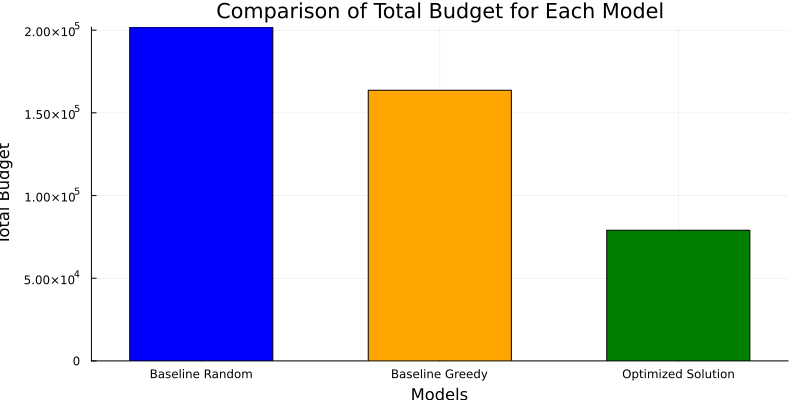

In [165]:
using Plots
using Statistics

models = ["Baseline Random", "Baseline Greedy", "Optimized Solution"]

# Calculate the total budget for each model
total_values = [
    sum([baseline_random[company]["random_budget"] for company in companies_l]),
    sum([baseline_greedy[company]["greedy_budget"] for company in companies_l]),
    sum([optimized_solutions[company]["optimal_budget"] for company in companies_l])
]

# Bar graph comparing total budget for each model
bar_plot_total = bar(
    models,
    total_values,
    label="Total Budget",
    title="Comparison of Total Budget for Each Model",
    xlabel="Models",
    ylabel="Total Budget",
    legend=:none,
    bar_width=0.6,
    size=(800, 400),
    color=[:blue, :orange, :green]
)

display(bar_plot_total)


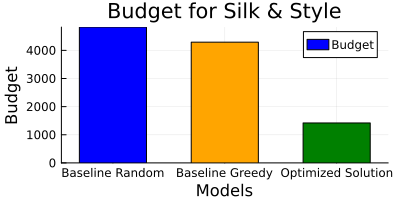

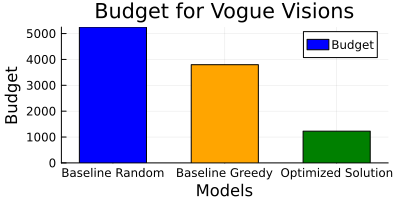

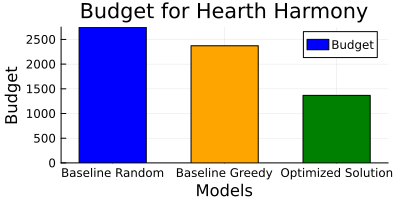

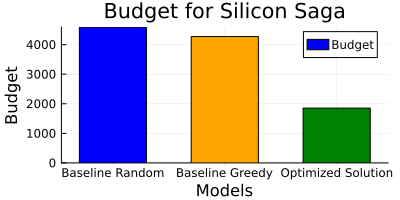

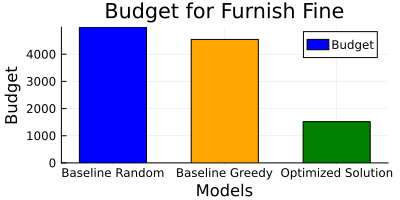

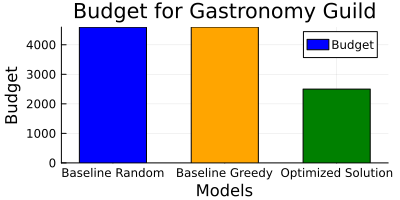

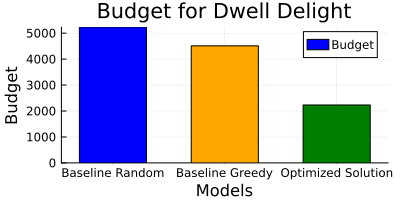

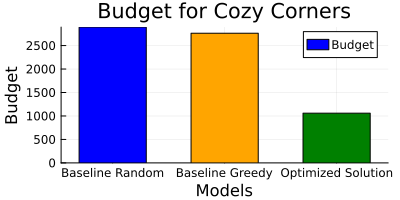

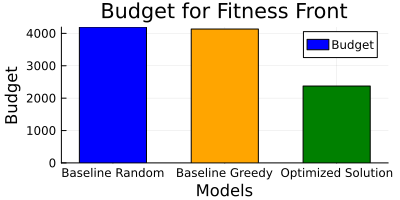

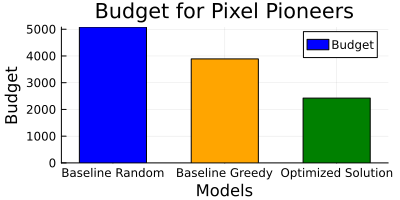

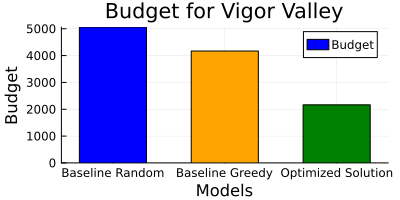

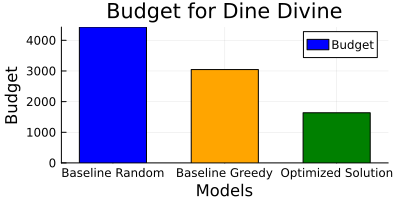

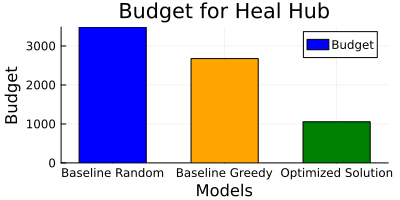

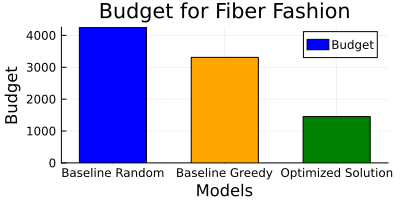

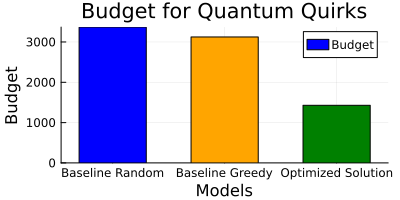

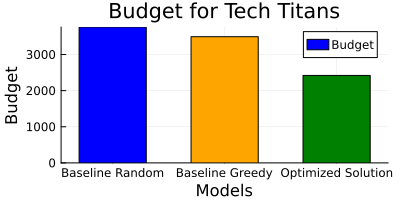

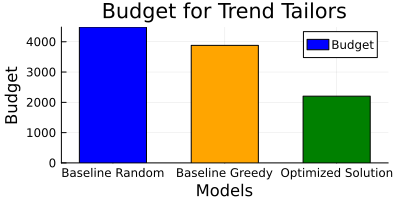

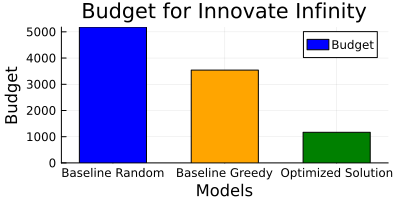

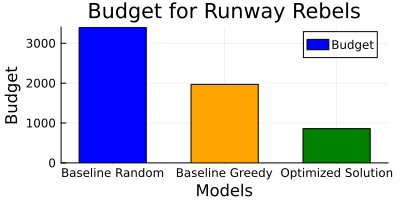

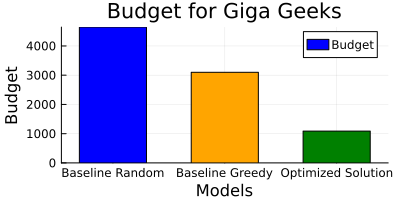

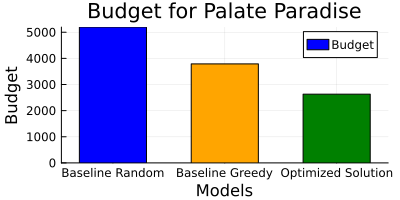

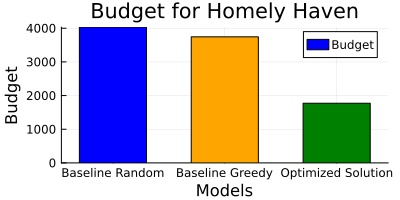

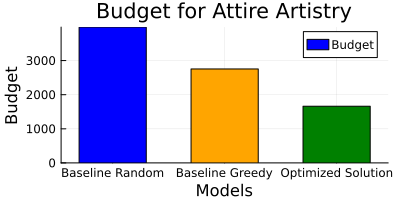

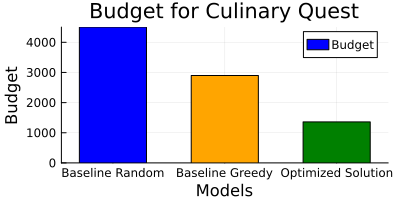

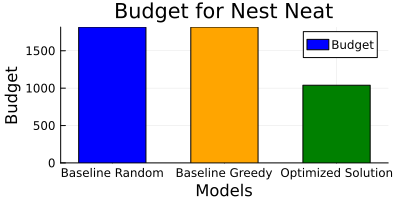

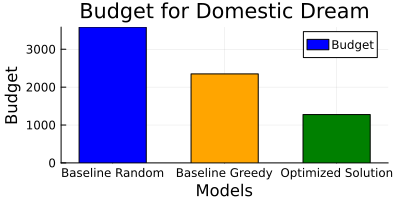

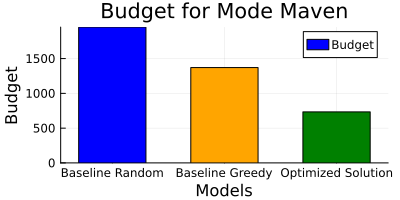

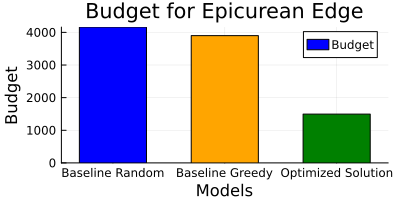

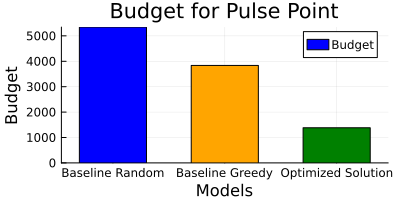

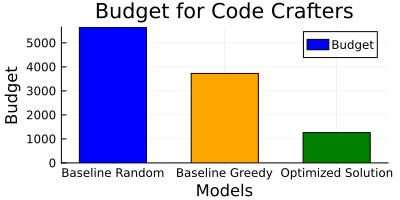

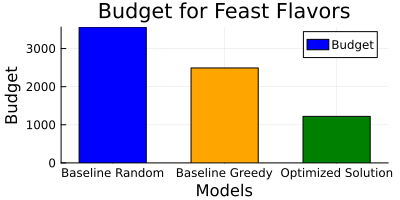

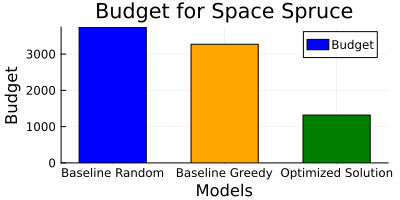

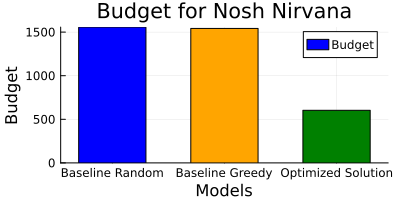

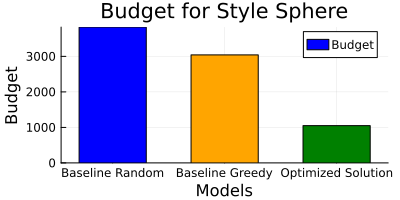

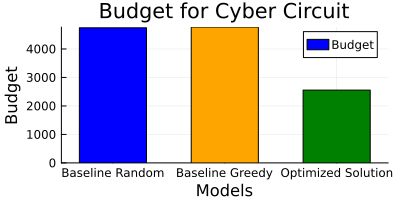

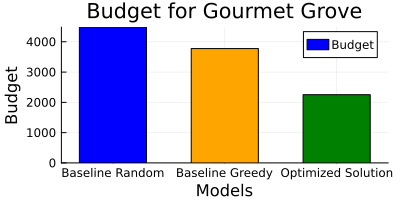

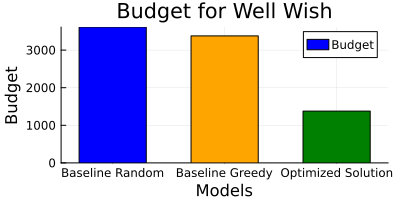

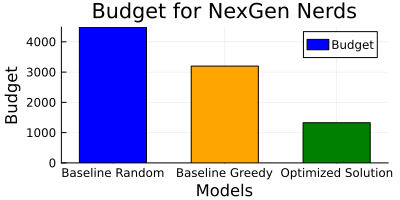

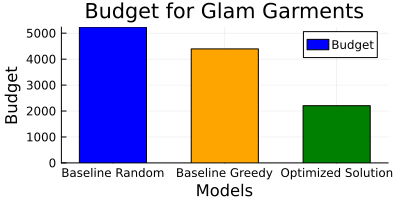

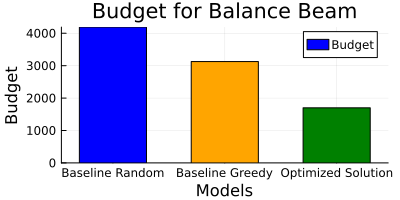

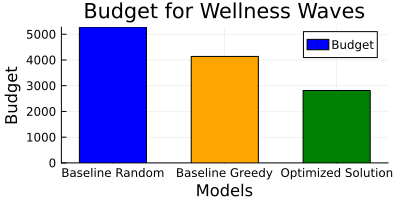

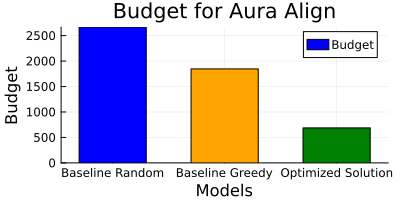

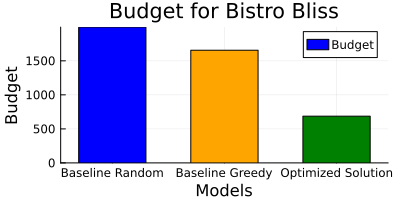

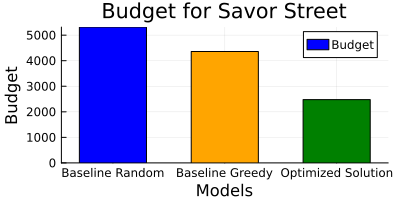

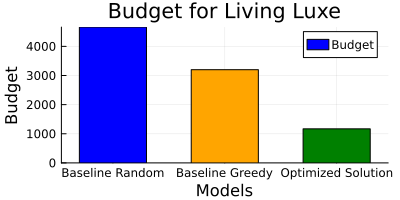

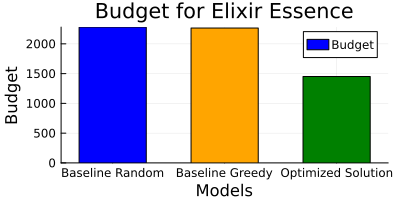

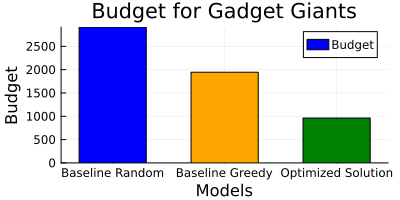

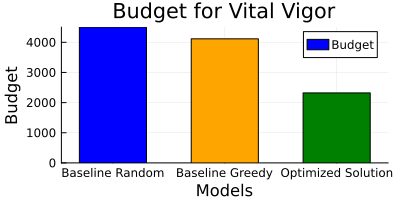

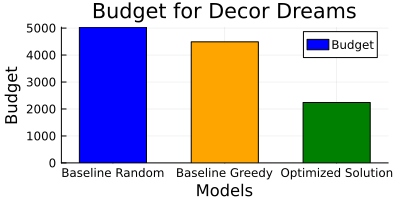

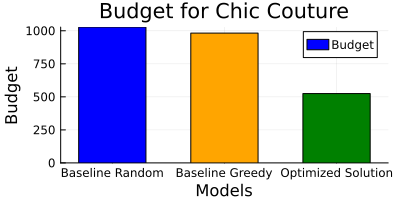

In [160]:
# Function to create a bar plot for each company
function create_bar_plot(company_name, company_data)
    return bar(
        models,
        company_data,
        label="Budget",
        title="Budget for $company_name",
        xlabel="Models",
        ylabel="Budget",
        legend=:topright,
        bar_width=0.6,
        size=(400, 200),
        color=[:blue, :orange, :green]  # Colors for the models
    )
end

# Generate and display bar plots for each company
for company in companies_l
    company_data = [baseline_random[company]["random_budget"], baseline_greedy[company]["greedy_budget"], optimized_solutions[company]["optimal_budget"]]
    bar_plot_company = create_bar_plot(company, company_data)
    display(bar_plot_company)
end

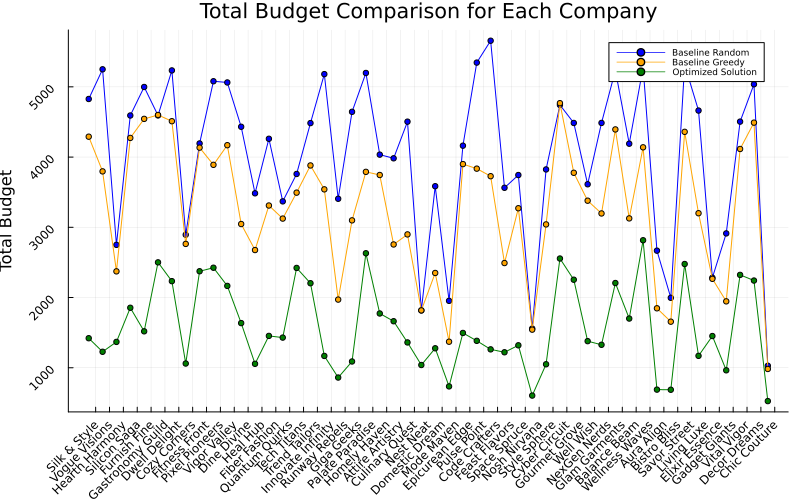

In [180]:
using Plots

# Prepare data for the line plot
total_budget_random = [sum(baseline_random[company]["random_budget"]) for company in companies_l]
total_budget_greedy = [sum(baseline_greedy[company]["greedy_budget"]) for company in companies_l]
total_budget_optimized = [sum(optimized_solutions[company]["optimal_budget"]) for company in companies_l]

# Create the line plot with dots
line_plot = plot(
    companies_l,  # x-axis: companies
    total_budget_random,  # y-values for the first line (Baseline Random)
    label="Baseline Random",  # Label for the first line
    color=:blue,  # Color for the first line
    linestyle=:solid,  # Line style
    markershape=:circle,  # Shape of the markers (dots)
    markersize=3,  # Size of the markers
    xlabel="Companies",  # x-axis label
    ylabel="Total Budget",  # y-axis label
    title="Total Budget Comparison for Each Company",  # Title of the plot
    size=(800, 500),  # Size of the plot
    legend=:topright,
    legendfontsize=6
)

# Add the second line (Baseline Greedy)
plot!(
    companies_l,  # x-axis: companies
    total_budget_greedy,  # y-values for the second line (Baseline Greedy)
    label="Baseline Greedy",  # Label for the second line
    color=:orange,  # Color for the second line
    linestyle=:solid,  # Line style
    markershape=:circle,  # Shape of the markers (dots)
    markersize=3  # Size of the markers
)

# Add the third line (Optimized Solution)
plot!(
    companies_l,  # x-axis: companies
    total_budget_optimized,  # y-values for the third line (Optimized Solution)
    label="Optimized Solution",  # Label for the third line
    color=:green,  # Color for the third line
    linestyle=:solid,  # Line style
    markershape=:circle,  # Shape of the markers (dots)
    markersize=3,  # Size of the markers
    xticks=(1:length(companies_l), companies_l),  # Set x-ticks with company names
    rotation=45  # Rotate x-tick labels by 45 degrees
)

# Display the plot
display(line_plot)
